In [1]:
from dotenv import load_dotenv

import os

load_dotenv()

True

## Checando Tools 

Vamos importar as tools criadas anteriormente! 

In [2]:
from tools import *

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
trends = create_trends_tool()
trends_text = trends.invoke({"country": "brazil", 
                             "head": 3})
trends_list = to_list(trends_text)
trends_list

['Resultado TSE Unificado', 'Campeonato Carioca', 'Cruzeiro x São Paulo']

In [4]:
contents_news = get_serper_with_scrapping(trends_list, k=5)

100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


In [5]:
contents_news

{'Resultado TSE Unificado': [{'title': 'Concurso Unificado da Justiça Eleitoral: resultado das provas objetivas deve ocorrer até as 18h de hoje (15)',
   'link': 'https://www.tse.jus.br/comunicacao/noticias/2025/Janeiro/resultado-das-provas-objetivas-deve-ser-divulgado-ate-as-18h-de-hoje-15',
   'snippet': 'O Tribunal Superior Eleitoral (TSE) informa que o edital de resultado final das provas objetivas, para todos os cargos, do Concurso Público...',
   'date': 'há 6 horas',
   'source': 'Tribunal Superior Eleitoral',
   'imageUrl': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSgpaLGVJ3mQIp3rS08dT4mzqcNOww4Xg_qbgLk9St8cecwmVXcshQ9BwBR0w&s',
   'position': 1,
   'content': '\n\n\n\n\n\nConcurso Unificado da Justiça Eleitoral: resultado das provas objetivas deve ocorrer até as 18h de hoje (15) — Tribunal Superior Eleitoral\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAcessibilidade\n\n\n\n\nRybená acessibilidades adicionais\n\n\nRybená Libras\n\n\nRybená vo

## Construção do Agent

Para construir o agente, vamos utilizar as funções que construimos anteriormente. A ideia central é um agente que colete quais são as tendências de pesquisa no Google Trends, pesquise essas tendências no Google Api (SerpApi), faça scrapping dos resultados e crie uma newsletter com as informações. Para a construção desses fluxos, é comum fazermos o desenho do fluxo (que pode ser representado por um grafo).

<img src="../imgs/agent_trends.png" width="800">

Os componentes do agente são:

1. ``Estado``: é o objeto que irá armazenar as informações do agente ao longo do grafo.
2. ``Nós``: são as funções que irão realizar as ações do agente.
3. ``Transições (arestas)``: são as funções que irão decidir qual será o próximo nó a ser executado (ela pode ser condicional ou não).

### Estado do Grafo

In [6]:
from typing_extensions import TypedDict
from typing import List, Dict, Any

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        country: country of the trends
        head: number of trends to get
        k: number of news to get
        trends: list of trends
        news: dict of news about each trend
        newsletter: newsletter from the news
    """
    country: str
    head: int
    k: int
    trends: List[str]
    news: dict
    newsletter: str

### Chains

Aqui definimos as cadeias de execução do agente. Normalmente separamos dessa forma pra que a construção dos nós fique mais organizada.

In [7]:

from operator import itemgetter
from typing import TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

def format_news(news: dict) -> str:
    """
    Format the news to be used in the newsletter.

    Args:
        news: dict of news about each trend

    Returns:
        str: formatted news
    """
    news_str = ""
    for trend, content in news.items():
        news_str += f"-----**{trend}**-----\n"
        for i, new in enumerate(content):
            title = new["title"]
            txt_content = new["content"]
            link = new["link"]
            
            news_str += f"""
            title: {title}
            link: {link}
            content: {txt_content}
            """
        news_str += "\n"
    return news_str

def write_newsletter(news: dict, 
                     provider: str="openai",
                     model_name: str="gpt-4o-mini",
                     temperature: float=0.2) -> str:
    """
    Generate a newsletter from the news.
    
    Args:
        news: dict of news about each trend
        provider: provider of the language model
        model_name: name of the language model
        temperature: temperature of the language model
        
    Returns:
        str: newsletter from the news
    """
    
    if provider == "openai": # Sugestão: gpt-4o-mini
        llm = ChatOpenAI(model=model_name, temperature=temperature)
    elif provider == "groq": # Sugestão: llama-3.3-70b-versatile
        llm = ChatGroq(model=model_name, temperature=temperature)

    formatted_news = format_news(news)

    system_prompt = """
    Você é um assistente pessoal que vai escrever um newsletter sobre as notícias do dia que foram extraidas do Google Trends. Sua tarefa é resumir o conteúdo das notícias e escrever um texto informativo e interessante para o usuário. 
    
    Obs.: Sempre que possível, cite a fonte das notícias colocando o link de onde ela foi tirada.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Aqui está todo o conteúdo que você vai usar para fazer a newslette: {input}"),
        ]
    )

    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke({"input": formatted_news})
    
    return response

### Nodes

Aqui vamos definir os nós do grafo! Como dito anteriormente, entenda os nós como sendo funções a serem executadas. Cada entrada de um nó é a saída de um nó anterior, cada execução de nó podemos ou não modificar o estado do grafo (definido anteriormente).

In [8]:
from IPython.display import Markdown

def get_trends(state: GraphState) -> dict:
    """
    Get trends from Google Trends

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET TRENDS---")
    print()
    country = state["country"]
    head = state["head"]

    # Get trends
    trends = create_trends_tool()
    trends_text = trends.invoke({"country": country, 
                                 "head": head})
    trends_list = to_list(trends_text)
    
    print("Trend List: ", trends_list)
    print()
    
    return {"country": country, 
            "head": head, 
            "trends": trends_list}

def get_serper_and_scrapping(state: GraphState) -> dict:
    """
    Get news from SerpAPI and scrap the content

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET SERPER AND SCRAPPING---")
    print()
    trends = state["trends"]
    k = state["k"]
    
    # Get news
    news = get_serper_with_scrapping(queries=trends, 
                                              k=k)
    keys_from_serper = news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(news[trend]))):
            print(news[trend][i]["title"])
        print()
    
    return {"news": news}

def create_newsletter(state: GraphState) -> dict:
    """
    Create a newsletter from the news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """

    print("---CREATE NEWSLETTER---")
    print()
    news = state["news"]
    
    # Create newsletter
    newsletter = write_newsletter(news=news, 
                                  provider="openai",
                                  model_name="gpt-4o-mini",
                                  temperature=0.2)
    print("Aqui está a newsletter: ", newsletter)
    display(Markdown(newsletter))
    return {"newsletter": newsletter}

### Workflow

Por fim, com os nós construidos e as cadeias definidas, podemos construir o workflow do agente.

In [9]:
from langgraph.graph import END, StateGraph

def compile_workflow():
    """ 
    Compiles the workflow for creating a newsletter from Google Trends.
    
    Returns:
        app (StateGraph): The compiled workflow.
    """
    
    # Define the graph
    workflow = StateGraph(GraphState)
    
    # Define the nodes
    workflow.add_node("get_trends", get_trends)
    workflow.add_node("get_serper_and_scrapping", get_serper_and_scrapping)
    workflow.add_node("create_newsletter", create_newsletter)

    # Build graph
    workflow.set_entry_point('get_trends')
    workflow.add_edge("get_trends", "get_serper_and_scrapping")
    workflow.add_edge("get_serper_and_scrapping", "create_newsletter")
    workflow.add_edge("create_newsletter", END)

    # Compile
    app = workflow.compile()
    return app

In [10]:
app = compile_workflow()

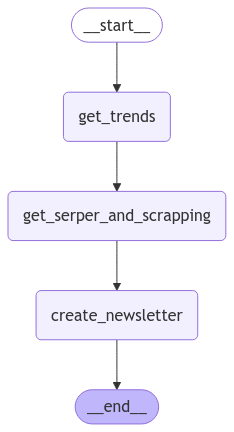

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [11]:
response = app.invoke({"country": "brazil",
                       "head": 5,
                       "k": 3})

---GET TRENDS---

Trend List:  ['Resultado TSE Unificado', 'Campeonato Carioca', 'Cruzeiro x São Paulo', 'Paulista', 'Delegado morto']

---GET SERPER AND SCRAPPING---



100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


---Resultado TSE Unificado---
Concurso Unificado da Justiça Eleitoral: resultado das provas objetivas deve ocorrer até as 18h de hoje (15)
Resultado do concurso TSE Unificado é divulgado; veja como acessar
Concurso TSE Unificado: SAIU o resultado final da prova objetiva!

---Campeonato Carioca---
Botafogo mostra evolução e vence a Portuguesa no Campeonato Carioca
LIVE | Pós-jogo de Botafogo 2×0 Portuguesa pelo Campeonato Carioca
Onde assistir ao vivo Botafogo x Portuguesa-RJ pelo Campeonato Carioca 2025

---Cruzeiro x São Paulo---
Cruzeiro x São Paulo tem resultado cravado pela Inteligência Artificial
Cruzeiro x São Paulo: onde assistir ao vivo, horário e escalações
Cruzeiro x São Paulo: horário e onde assistir ao amistoso da FC Series

---Paulista---
Quem são os favoritos para avançar no Campeonato Paulista? Veja
Ponte larga no Paulista para recuperar a imagem perdida
Palmeiras estreia no Paulista contra a Portuguesa; saiba sobre a preparação

---Delegado morto---
Delegado morto: polí

### Newsletter de Notícias - 15 de Janeiro de 2025

#### 1. **Resultado do Concurso Unificado da Justiça Eleitoral**
O Tribunal Superior Eleitoral (TSE) divulgou hoje, até as 18h, os resultados das provas objetivas do Concurso Público Nacional Unificado da Justiça Eleitoral (CPNUJE). Os candidatos podem acessar os resultados no site do Cebraspe, a banca responsável pelo certame. O concurso oferece 412 vagas para os cargos de analista e técnico judiciário, com salários que variam entre R$ 8.529,67 e R$ 13.994,78. O resultado final está previsto para junho de 2025. [Leia mais aqui](https://www.tse.jus.br/comunicacao/noticias/2025/Janeiro/resultado-das-provas-objetivas-deve-ser-divulgado-ate-as-18h-de-hoje-15).

#### 2. **Botafogo Vence Portuguesa no Campeonato Carioca**
O Botafogo conquistou sua primeira vitória no Campeonato Carioca 2025 ao derrotar a Portuguesa por 2 a 0, com gols de Kauê e Kayke. O jogo foi realizado no Estádio Nilton Santos e marcou uma evolução na equipe, que busca se reabilitar após uma estreia frustrante. O próximo desafio do Botafogo será contra o Sampaio Corrêa. [Leia mais aqui](https://odia.ig.com.br/esporte/botafogo/2025/01/6985875-botafogo-mostra-evolucao-e-vence-a-portuguesa-no-campeonato-carioca.html).

#### 3. **Delegado Morto em São Paulo**
O delegado Josenildo Belarmino de Moura Júnior, de 32 anos, foi morto a tiros durante uma tentativa de assalto na zona sul de São Paulo. Ele estava na função há apenas dois meses e havia sido nomeado em maio de 2024. A polícia investiga o caso e busca identificar os suspeitos. O governador de São Paulo, Tarcísio de Freitas, afirmou que as forças policiais estão empenhadas na captura do criminoso. [Leia mais aqui](https://www.cnnbrasil.com.br/nacional/sudeste/sp/veja-o-que-se-sabe-sobre-o-caso-do-delegado-morto-com-tiro-nas-costas-em-sao-paulo/).

#### 4. **Cruzeiro e São Paulo se Enfrentam em Amistoso**
Cruzeiro e São Paulo se enfrentam hoje, às 21h30, em um amistoso nos Estados Unidos, parte da FC Series. A partida contará com a estreia de reforços como Gabigol e Dudu pelo Cruzeiro. A transmissão será feita pelo Sportv e outras plataformas. [Leia mais aqui](https://ge.globo.com/futebol/noticia/2025/01/15/cruzeiro-x-sao-paulo-onde-assistir-ao-vivo-horario-e-escalacoes.ghtml).

#### 5. **Campeonato Paulista Começa Hoje**
O Campeonato Paulista de 2025 começa hoje com quatro jogos, incluindo Palmeiras x Portuguesa, que será transmitido pela Record e outras plataformas. O Paulistão traz novidades, como o sistema de multiball para agilizar o jogo, inspirado na Premier League. [Leia mais aqui](https://www.sportingnews.com/br/futebol/noticias/onde-assistir-paulistao-quem-vai-transmitir-campeonato-paulista/2f47a16aac2c8f4a778d1115).

#### 6. **Bangu Fecha Acordo com Patrocinador**
O Bangu anunciou uma nova parceria com a empresa de materiais de construção Obramax para a disputa do Campeonato Carioca. A logo da empresa será exibida nas camisas do time. O Bangu busca se reerguer após uma estreia difícil no campeonato. [Leia mais aqui](https://odia.ig.com.br/esporte/2025/01/6986353-bangu-fecha-acordo-com-patrocinador-para-a-disputa-do-carioca.html).

Fique atento às atualizações e não perca as próximas notícias!

## Conclusão:

Com essa aplicação simples é possível ver como podemos construir um agente que coleta informações de tendências de pesquisa e cria uma newsletter. Para além dessa ideia, é possível construir aplicações mais robustas, que envolvem ``novos nós, novas cadeias, novos estados ou até transições condicionais``. 

### Tarefa de casa:

1. Crie um novo nó que envie a newsletter por email. Note que para isso você precisa incluir uma lista de emails que irão receber a newsletter. (``Dica:`` Faça a lista de emails ser um parâmetro na entrada do grafo, assim você pode passar a lista de emails como parâmetro para o nó que envia a newsletter).

2. Calcule quanto custa em média uma newsletter. (``Dica:`` Use o LangSmith).

3. Construa um classificador que classifica as notícias de acordo com o assunto. Especificamente, classifique se a notícia fala sobre futebol ou não (``binário``). No fim, faça a newsletter somente baseada em assuntos de futebol (seu classificador será um filtro).

4. Crie um ``conditional_edge`` que verifica se existe noticia ou não de futebol. Caso não tenha noticias de futebol no Google Trends, crie um nó que vai pesquisar sobre seu time de futebol favorito e adicione na newsletter apenas os ultimos assuntos dele.

5. Crie uma ``API`` (com ``FastAPI``, por exemplo), que contenha um endpoint que recebe:

```python
{"country": "brazil",
 "head": 5,
 "k": 3}
 ```

E devolve o estado do grafo.